In [1]:
# ─── Standard­bibliothek ────────────────────────────────────────────────────────
import math

# ─── Data Handling ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─── Visualisierung ────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

# ─── Scikit-Learn: Pipeline & Preprocessing ─────────────────────────────────────
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# ─── Scikit-Learn: Modell­auswahl & Hyperparameter­suche ─────────────────────────
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)

# ─── Scikit-Learn: Modelle & Feature Selection ──────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# ─── Scikit-Learn: Metriken & Aus­gabe ──────────────────────────────────────────
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# ─── Eigene Encoder / Transformer ────────────────────────────────────────────────
from sklearn.base import BaseEstimator, TransformerMixin
# from category_encoders import BinaryEncoder  # falls du die Bibliothek nutzt
# oder definiere hier deinen eigenen BinaryEncoder


## 1. Daten laden und vorbereiten
Zunächst laden wir den Mushroom-Datensatz in einen DataFrame und führen einige Vorverarbeitungsschritte durch:   

Laden der CSV-Daten: Wir gehen davon aus, dass die Datei mushrooms.csv im Ordner data/ vorliegt (mit Header und allen Spaltennamen).      Bereinigen fehlender Werte: Einige Einträge bei stalk-root sind mit "?" markiert (fehlender Wert). Diese Zeilen entfernen wir aus dem Datensatz.    

Kodieren der Zielvariablen: Die Spalte class enthält die Klassenbezeichnung 'e' (edible, essbar) oder 'p' (poisonous, giftig). Wir erstellen eine neue numerische Zielspalte target mit 0 für essbar und 1 für giftig.  
    
Optional: Features ausschließen: Standardmäßig verwenden wir alle verfügbaren Merkmale. Möchte man bestimmte Merkmale ausschließen (z. B. um den Einfluss sehr starker Prädiktoren wie odor zu untersuchen), kann man diese in einer Liste exclude_features angeben – diese würden dann aus dem DataFrame entfernt.      

Train/Test-Split: Wir teilen die Daten stratifiziert in Trainings- und Testset (80/20 Aufteilung), um die Modelle anschließend unabhängig auf dem Testset bewerten zu können. Die Stratifizierung stellt sicher, dass das Verhältnis von essbaren/giftigen Pilzen in beiden Sets identisch ist.


In [2]:
# 1. Daten laden
df = pd.read_csv('data/mushrooms.csv')
print(f"Datensätze geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten.")

# 2. Bereinigen und Zielvariable kodieren
# 2.1 Zeilen mit fehlendem Wert ('?') bei 'stalk-root' entfernen
df = df[df['stalk-root'] != '?'].reset_index(drop=True)
# 2.2 Zielvariable kodieren ('e'->0, 'p'->1) und in neuer Spalte 'target' speichern
df['target'] = df['class'].map({'e': 0, 'p': 1})

# 2.3 Optionale Liste starker Merkmale, die ausgeschlossen werden können
strong_features = ['odor', 'spore-print-color', 'gill-color']
exclude_features = []  # z.B. = strong_features, um diese zu entfernen (hier leer lassen für alle Features)

if exclude_features:
    df.drop(columns=exclude_features, inplace=True)
    print(f"Folgende Merkmale wurden ausgeschlossen: {exclude_features}")

# 2.4 Merkmalsmatrix X und Zielvektor y definieren
X = df.drop(columns=['class', 'target'])
y = df['target']

print("Verbleibende Features:", list(X.columns))
print("Klassenverteilung (target):", np.bincount(y))
# Ausgabe: Verbleibende Features und Klassenverteilung


Datensätze geladen: 8124 Zeilen, 23 Spalten.
Verbleibende Features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Klassenverteilung (target): [3488 2156]


### 2. Train/Test-Split und Cross-Validation

Bevor wir die verschiedenen Pipelines aufsetzen, teilen wir die Daten in Trainings- und Testmenge. Zudem definieren wir das Cross-Validation-Verfahren für die Hyperparameterabstimmung:

    Train/Test-Split: 80% Training, 20% Test (stratifiziert nach der Zielvariable).

    Cross-Validation (CV): Wir verwenden StratifiedKFold mit 5 Folds und shuffle=True (mit festem random_state für Reproduzierbarkeit). Dadurch wird die Trainingsmenge in 5 Teile aufgeteilt und das Training pro Hyperparameter-Kombination 5-mal mit wechselnden Validierungs-Splits durchgeführt.

Diese CV-Strategie nutzen wir später in RandomizedSearchCV, um die Hyperparameter der Modelle abzustimmen.

In [3]:
# 3. Stratified Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Trainingsdaten: {X_train.shape[0]} Beispiele, Testdaten: {X_test.shape[0]} Beispiele")

# 4. Cross-Validation Setup (5-fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Trainingsdaten: 4515 Beispiele, Testdaten: 1129 Beispiele


### 3. Definition verschiedener Encoder und Pipeline-Komponenten

Bevor wir die eigentlichen Modelle trainieren, bereiten wir für jede Encodierungsstrategie einen Transformationsschritt vor. Alle Encoder sollen nur auf die kategorischen Spalten (hier: alle Merkmale in X) angewandt werden. Anschließend kombinieren wir diese Encoder mit den jeweiligen Modellen in Scikit-Learn Pipelines.

#### 3.1 Ordinal Encoder

OrdinalEncoder: Dieser Encoder wandelt kategorische Werte in nummerische Labels um (0, 1, 2, ...). Dabei wird keine besondere Ordnung der Kategorien angenommen, außer man gibt sie explizit vor. Für Features mit echter ordinaler Bedeutung (wie ring-number: none, one, two) kann man die Reihenfolge der Kategorien so angeben, dass die Zahlenwerte der natürlichen Rangfolge entsprechen. Bei nominalen Features hingegen gibt es keine natürliche Reihenfolge – in solchen Fällen nutzt der OrdinalEncoder intern alphabetische Sortierung der Werte, was dem Modell aber eine willkürliche Ordnung suggeriert.

Vorteil: Sparsam (es entsteht nur eine Spalte pro Feature). Nachteil: Bei nominalen Kategorien kann das Modell fälschlicherweise eine lineare Rangordnung interpretieren; für lineare Modelle kann dies ungeeignet sein, während Baum-Modelle damit oft umgehen können (sie können die integer-Codes wie Kategorien behandeln, wenn auch ohne explizites Verständnis der Unterschiedlichkeit).

Wir wenden den OrdinalEncoder auf alle verbliebenen kategorialen Spalten an. Unbekannte Kategorien (falls im Testset welche auftreten sollten) werden auf einen speziellen Wert (-1) gemappt.

In [4]:
# Kategoriale Spaltenliste (hier: alle Spalten von X_train)
categorical_cols = X_train.columns.tolist()

# OrdinalEncoder vorbereiten (unbekannte Kategorien -> -1)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord_preprocessor = ColumnTransformer(
    transformers=[('ord', ordinal_encoder, categorical_cols)],
    remainder='drop'
)


#### 3.2 One-Hot Encoder

OneHotEncoder: Dieser Encoder erstellt für jede Kategorie eines Features eine eigene Dummy-Spalte mit 0/1-Codierung. Ein Beispiel: Ein Merkmal cap-color mit Werten {red, yellow, green, ...} würde z. B. in mehrere Spalten cap-color_red, cap-color_yellow, cap-color_green, ... umgewandelt. Der Wert 1 steht dann für das Vorhandensein der jeweiligen Kategorie.

Vorteil: Es entsteht keine falsche ordinale Beziehung zwischen Kategorien, da jedes Kategorie-Label separat behandelt wird. Modelle (insbesondere lineare Modelle) können so für jede Kategorie einen eigenen Parameter lernen. Nachteil: Bei vielen Kategorien pro Feature oder vielen Features insgesamt steigt die Dimension des Feature-Vektors stark an (Fluch der Dimensionalität). Zudem entstehen viele dünn besetzte (spärliche) Features.

Wir nutzen den OneHotEncoder von Scikit-Learn. Parameter handle_unknown='ignore' sorgt dafür, dass unbekannte Kategorien (im Test) ignoriert werden (statt Fehler zu werfen). Wir fordern ein dichtes Ausgabeformat (sparse_output=False), um es kompatibel mit den Pipeline-Schritten (z. B. Feature-Selection, StandardScaler) zu machen.

In [ ]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_preprocessor = ColumnTransformer(
    transformers=[('onehot', onehot_encoder, categorical_cols)],
    remainder='drop'
)


#### 3.3 Binary Encoder

Binary Encoding: Dies ist ein alternatives Kodierungsverfahren (nicht direkt in Scikit-Learn enthalten, aber über Category Encoders Bibliothek oder eigene Implementierung möglich). Dabei wird jede Kategorie zunächst einem eindeutigen integer Code zugewiesen (ähnlich wie Ordinal-Encoding, aber ohne implizite Ordnung). Anschließend wird dieser Code im binären Zahlensystem dargestellt, und jede Bitstelle wird zu einem eigenen binären Feature.

Beispiel: Hat ein Feature 5 Kategorien, werden 3 Bits benötigt (weil 2^3 = 8 ≥ 5). Angenommen die Kategorien A, B, C, D, E bekommen Codes 0,1,2,3,4. Diese werden binär: A=000, B=001, C=010, D=011, E=100. Dann entstehen 3 neue Spalten (Bit0, Bit1, Bit2), die je nach Kategorie mit 0/1 gefüllt werden. So teilen sich Kategorien gewisse Bits, was die Dimension stark reduziert (nur log2(N) Spalten pro Feature, statt N bei One-Hot). Nachteil: Die Interpretation der einzelnen Bits ist schwieriger, und es können Kollisionen auftreten: Zwei verschiedene Kategorien können in manchen Bits gleiche Werte haben. Lineare Modelle können dann Kategorien nicht vollständig auseinanderhalten (nicht linear separabel im Bit-Raum), während Baum-Modelle mit Kombinationen von Bit-Spalten ggf. umgehen können.

Wir implementieren einen einfachen Binary Encoder selbst und verwenden ihn für alle kategorialen Spalten. (Bei sehr hoher Kardinalität könnte alternativ ein Hashing-Trick verwendet werden, der ähnlich funktioniert, aber randomisierte Kollisionen einführt.)

Wir haben den BinaryEncoder so gestaltet, dass er unbekannte Kategorien zur Not mit einem neuen Code versieht. Allerdings kann dies dazu führen, dass zur Laufzeit ein zusätzliches Bit nötig wäre, was in unserer Implementierung nur dynamisch (zur Not) berücksichtigt wird. In unserem Datensatz erwarten wir keine völlig neuen Kategorien im Testset, daher sollte dieser Fall nicht eintreten.

In [ ]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    """Eigene Implementierung des Binary Encoding für kategoriale Features."""
    def __init__(self, cols=None):
        self.cols = cols  # zu kodierende Spalten
        self.category_maps = {}  # speichert Mapping von Kategorie -> Code je Spalte
        self.n_bits = {}         # Anzahl benötigter Bits je Spalte

    def fit(self, X, y=None):
        # Falls X ein DataFrame ist, kopieren; sonst in DataFrame umwandeln
        df = pd.DataFrame(X).copy()
        if self.cols is None:
            self.cols = df.columns.tolist()
        for col in self.cols:
            # Eindeutige Kategorien sammeln und Code zuweisen (0,1,2,...)
            unique_vals = sorted(df[col].unique())
            mapping = {val: idx for idx, val in enumerate(unique_vals)}
            self.category_maps[col] = mapping
            # Benötigte Bit-Anzahl für diese Spalte berechnen
            n_cat = len(unique_vals)
            # Mindestens 1 Bit, auch wenn nur 1 Kategorie (Edge-Case)
            bits = 1 if n_cat <= 1 else math.ceil(math.log2(n_cat))
            self.n_bits[col] = bits
        return self

    def transform(self, X):
        df = pd.DataFrame(X).copy()
        encoded_cols = []  # sammeln die kodierten Bit-Spalten als Series
        for col in self.cols:
            # Verwende gelerntes Mapping; unbekannte Werte bekommen Code = n_cat (neuer höchster Code)
            mapping = self.category_maps[col]
            n_cat = len(mapping)
            codes = df[col].apply(lambda val: mapping.get(val, n_cat)).astype(int)
            bits = self.n_bits[col]
            # Falls unbekannte Kategorie einen zusätzlichen Bit benötigt (selten), erhöhe Bits dynamisch
            if codes.max() >= (1 << bits):
                bits += 1
                self.n_bits[col] = bits
            # Erzeuge die Bit-Spalten
            for i in range(bits):
                bit_col = (codes >> i) & 1  # Bit i extrahieren
                bit_col.name = f"{col}_bit{i}"
                encoded_cols.append(bit_col)
        # Konkatenieren der Bit-Spalten zu einem DataFrame und als numpy zurückgeben
        encoded_df = pd.concat(encoded_cols, axis=1)
        return encoded_df.values


In [ ]:
# 1) Hyperparameter-Suchräume und Ergebnis-Container

rf_param_dist = {
    'clf__n_estimators': np.random.randint(50, 500, size=30),
    'clf__max_depth': [None] + list(np.random.randint(5, 50, size=5)),
    'clf__min_samples_split': np.random.randint(2, 20, size=10),
    'clf__max_features': [None, 'sqrt', 'log2']
}
lr_param_dist = {
    'clf__C': np.random.uniform(0.001, 10, size=20),
    'clf__penalty': ['l2', 'l1'],
    'clf__solver': ['saga']
}

best_models = {}
results_summary = []


In [ ]:
# ##### Encoding: OrdinalEncoder #####
print("##### Encoding: OrdinalEncoder #####")

# RF-Suche
ord_rf_search = RandomizedSearchCV(
    Pipeline([
        ('enc', ord_preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    rf_param_dist, n_iter=30, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
ord_rf_search.fit(X_train, y_train)
y_pred_ord_rf = ord_rf_search.predict(X_test)

# LR-Suche
ord_lr_search = RandomizedSearchCV(
    Pipeline([
        ('enc', ord_preprocessor),
        ('scale', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=10000, random_state=42))
    ]),
    lr_param_dist, n_iter=20, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
ord_lr_search.fit(X_train, y_train)
y_pred_ord_lr = ord_lr_search.predict(X_test)

# Ergebnisse speichern – hier die korrekte Zuordnung von Modell-Objekt und Name
for model_name, search_obj, y_pred in [
    ('RandomForest', ord_rf_search, y_pred_ord_rf),
    ('LogisticRegression', ord_lr_search, y_pred_ord_lr)
]:
    best_models[('Ordinal', model_name)] = search_obj.best_estimator_
    results_summary.append({
        'Encoder': 'Ordinal',
        'Model': model_name,
        'Train Accuracy': search_obj.score(X_train, y_train),
        'Test Accuracy': search_obj.score(X_test, y_test),
        'ROC-AUC': roc_auc_score(y_test, search_obj.predict_proba(X_test)[:,1])
    })

print("Done Ordinal")


##### Encoding: OrdinalEncoder #####
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done Ordinal


In [ ]:
# 3) OneHotEncoder + RandomForest und LogisticRegression
print("##### Encoding: OneHotEncoder #####")

# Random Forest mit OneHot
ohe_rf_pipe = Pipeline([
    ('enc', ohe_preprocessor),
    ('feature_sel', SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')),
    ('clf', RandomForestClassifier(random_state=42))
])
ohe_rf_search = RandomizedSearchCV(
    ohe_rf_pipe, rf_param_dist,
    n_iter=30, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
ohe_rf_search.fit(X_train, y_train)
y_pred_ohe_rf = ohe_rf_search.predict(X_test)

# Logistic Regression mit OneHot
ohe_lr_pipe = Pipeline([
    ('enc', ohe_preprocessor),
    ('scale', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=10000, random_state=42))
])
ohe_lr_search = RandomizedSearchCV(
    ohe_lr_pipe, lr_param_dist,
    n_iter=20, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
ohe_lr_search.fit(X_train, y_train)
y_pred_ohe_lr = ohe_lr_search.predict(X_test)

# Ergebnisse speichern
for model_name, search_obj, y_pred in [
    ('RandomForest', ohe_rf_search, y_pred_ohe_rf),
    ('LogisticRegression', ohe_lr_search, y_pred_ohe_lr)
]:
    best_models[('OneHot', model_name)] = search_obj.best_estimator_
    results_summary.append({
        'Encoder': 'OneHot',
        'Model': model_name,
        'Train Accuracy': search_obj.score(X_train, y_train),
        'Test Accuracy': search_obj.score(X_test, y_test),
        'ROC-AUC': roc_auc_score(y_test, search_obj.predict_proba(X_test)[:,1])
    })

print("Done OneHot") 


##### Encoding: OneHotEncoder #####
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done OneHot


In [13]:
# 4a) Fixed BinaryEncoder
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.category_maps = {}
        self.n_bits = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.cols)
        for col in self.cols:
            vals = sorted(df[col].unique())
            mapping = {v: i for i,v in enumerate(vals)}
            self.category_maps[col] = mapping
            bits = max(1, int(np.ceil(np.log2(len(vals)))))
            self.n_bits[col] = bits
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.cols)
        encoded = []
        for col in self.cols:
            mapping = self.category_maps[col]
            default = len(mapping)
            codes = df[col].map(mapping).fillna(default).astype(int).values  # numpy array
            bits = self.n_bits[col]
            # Bit-Extraktion auf Numpy-Array
            for i in range(bits):
                encoded.append(((codes >> i) & 1).reshape(-1,1))
        return np.hstack(encoded)

# 4b) Pipelines mit BinaryEncoder
print("##### Encoding: BinaryEncoder #####")

# Random Forest mit BinaryEncoder
bin_rf_search = RandomizedSearchCV(
    Pipeline([
        ('enc', BinaryEncoder(cols=categorical_cols)),
        ('feature_sel', SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    rf_param_dist, n_iter=30, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
bin_rf_search.fit(X_train, y_train)
y_pred_bin_rf = bin_rf_search.predict(X_test)

# Logistic Regression mit BinaryEncoder
bin_lr_search = RandomizedSearchCV(
    Pipeline([
        ('enc', BinaryEncoder(cols=categorical_cols)),
        ('scale', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=10000, random_state=42))
    ]),
    lr_param_dist, n_iter=20, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)
bin_lr_search.fit(X_train, y_train)
y_pred_bin_lr = bin_lr_search.predict(X_test)

# Ergebnisse speichern
for model_name, search_obj, y_pred in [
    ('RandomForest', bin_rf_search, y_pred_bin_rf),
    ('LogisticRegression', bin_lr_search, y_pred_bin_lr)
]:
    best_models[('Binary', model_name)] = search_obj.best_estimator_
    results_summary.append({
        'Encoder': 'Binary',
        'Model': model_name,
        'Train Accuracy': search_obj.score(X_train, y_train),
        'Test Accuracy': search_obj.score(X_test, y_test),
        'ROC-AUC': roc_auc_score(y_test, search_obj.predict_proba(X_test)[:,1])
    })

print("Done Binary")

##### Encoding: BinaryEncoder #####
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done Binary


#### 5. Auswertung der Ergebnisse

Nachdem alle Modelle trainiert und getestet sind, vergleichen wir die Performance der verschiedenen Ansätze. Wir betrachten vor allem:

    Genauigkeit (Accuracy) auf dem Testset und ggf. auf dem Trainset, um Overfitting abzuschätzen.

    ROC-AUC auf dem Testset.

    Konfusionsmatrizen für einen anschaulichen Vergleich der Fehlklassifikationen.

    ROC-Kurven für einen visuellen Vergleich der Modelle.

5.1 Performance-Vergleich in Tabellenform

Wir fassen die Ergebnisse in einer Tabelle zusammen:

Die Spalte Overfit_gap zeigt die Differenz zwischen Trainings- und Test-Accuracy (ein hoher Wert deutet auf Overfitting hin, da das Modell deutlich besser auf den Trainingsdaten performt als auf neuen Daten).

In [14]:
# Ergebnisse in DataFrame umwandeln und ausgeben
results_df = pd.DataFrame(results_summary)
results_df['Overfit_gap'] = results_df['Train Accuracy'] - results_df['Test Accuracy']
results_df = results_df.sort_values(['Encoder','Model']).reset_index(drop=True)
results_df[['Encoder', 'Model', 'Train Accuracy', 'Test Accuracy', 'ROC-AUC', 'Overfit_gap']]


,Encoder,Model,Train Accuracy,Test Accuracy,ROC-AUC,Overfit_gap
0,Binary,LogisticRegression,1.000000,1.000000,1.000000,0.000000
1,Binary,RandomForest,1.000000,1.000000,1.000000,0.000000
2,OneHot,LogisticRegression,1.000000,1.000000,1.000000,0.000000
3,OneHot,RandomForest,1.000000,1.000000,1.000000,0.000000
4,Ordinal,LogisticRegression,0.998893,0.999114,0.999993,-0.000222
5,Ordinal,RandomForest,1.000000,1.000000,1.000000,0.000000


5.2 Konfusionsmatrizen

Wir visualisieren die Konfusionsmatrix für jedes Modell, um zu sehen, welche Fehler gemacht wurden (False Positives vs. False Negatives):

Anhand der Konfusionsmatrizen können wir z.B. erkennen, ob ein Modell vor allem einen der beiden Klassen systematisch falsch klassifiziert (z.B. ob essbare Pilze irrtümlich als giftig markiert werden oder umgekehrt).

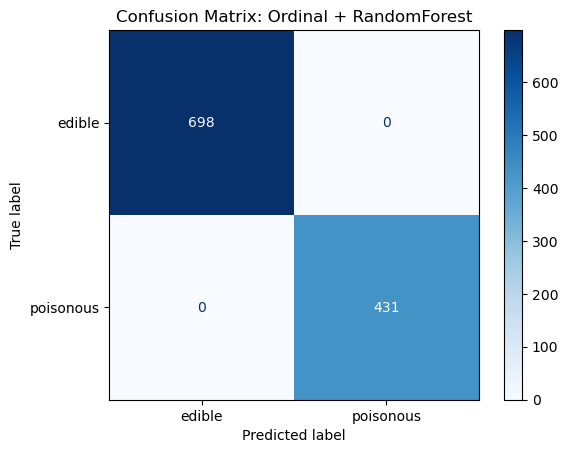

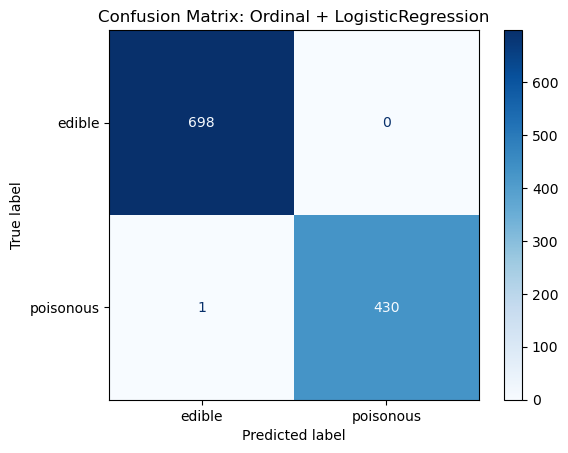

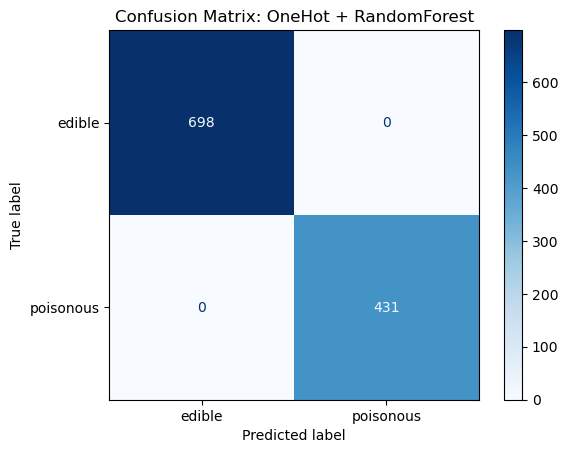

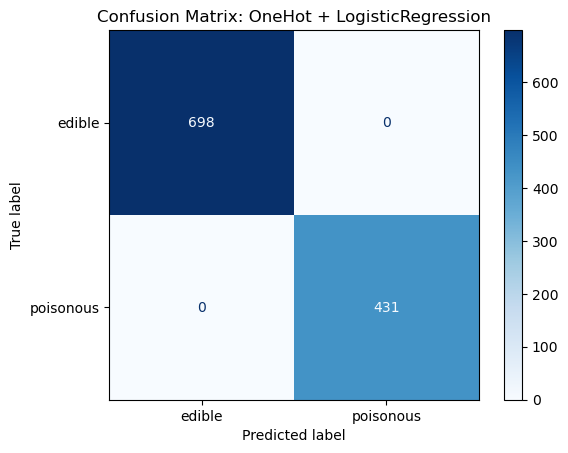

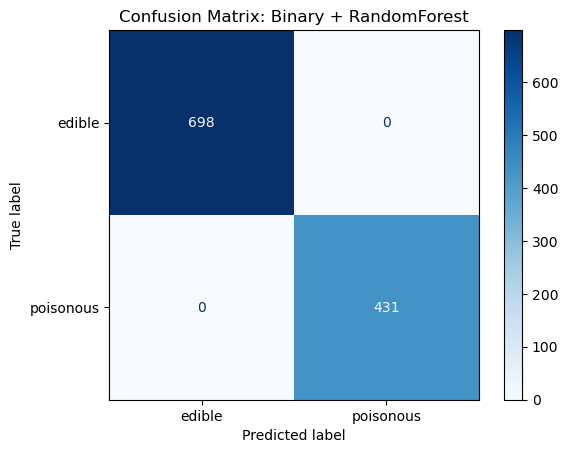

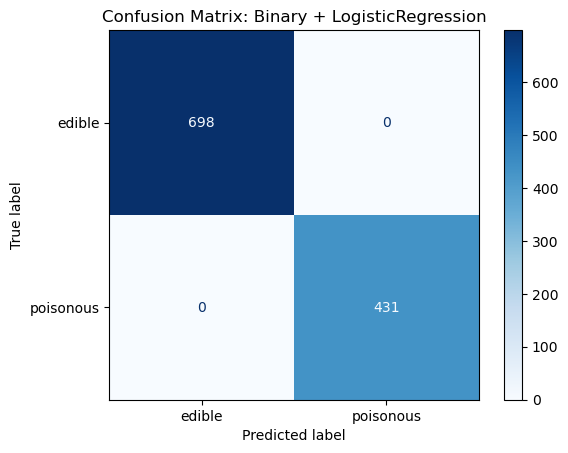

In [15]:
# Konfusionsmatrix Plot-Funktion für Kürze
def plot_confusion(model_key, y_true, y_pred):
    enc, mod = model_key
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=['edible','poisonous'], cmap=plt.cm.Blues, normalize=None
    )
    disp.ax_.set_title(f"Confusion Matrix: {enc} + {mod}")
    plt.show()

# Für jede Kombination die Konfusionsmatrix anzeigen
plot_confusion(('Ordinal','RandomForest'), y_test, y_pred_ord_rf)
plot_confusion(('Ordinal','LogisticRegression'), y_test, y_pred_ord_lr)
plot_confusion(('OneHot','RandomForest'), y_test, y_pred_ohe_rf)
plot_confusion(('OneHot','LogisticRegression'), y_test, y_pred_ohe_lr)
plot_confusion(('Binary','RandomForest'), y_test, y_pred_bin_rf)
plot_confusion(('Binary','LogisticRegression'), y_test, y_pred_bin_lr)


5.3 ROC-Kurven

Abschließend vergleichen wir die ROC-Kurven der Modelle. Um die Übersicht zu bewahren, plotten wir die ROC-Kurven gruppiert nach Modelltyp:

    ROC-Kurven der drei Encodings für Random Forest in einem Plot.

    ROC-Kurven der drei Encodings für Logistic Regression in einem separaten Plot.

<Figure size 600x500 with 0 Axes>

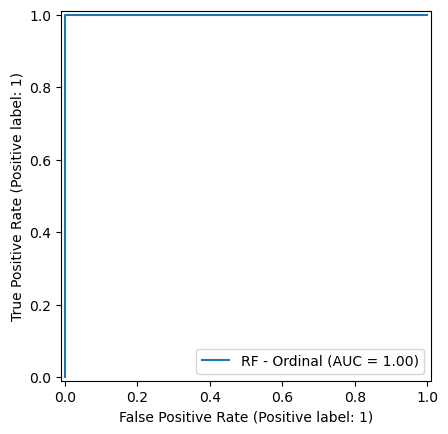

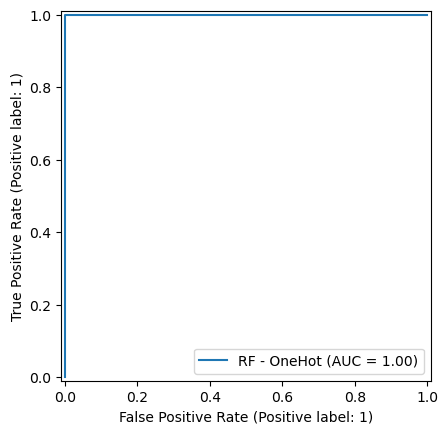

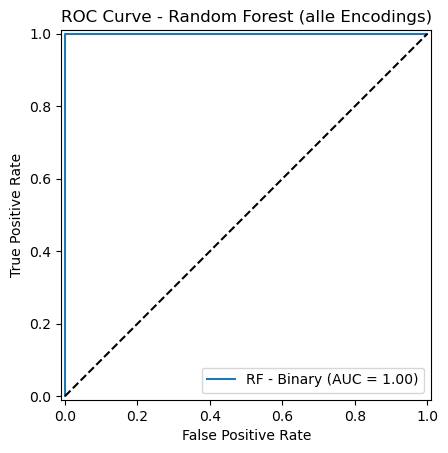

<Figure size 600x500 with 0 Axes>

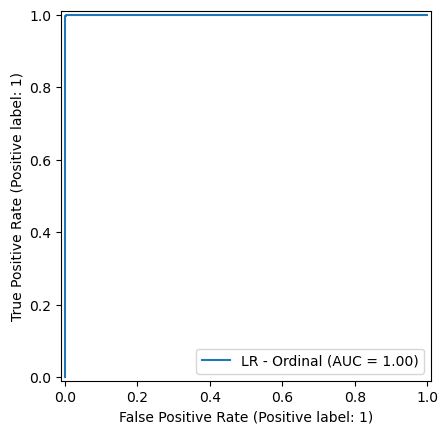

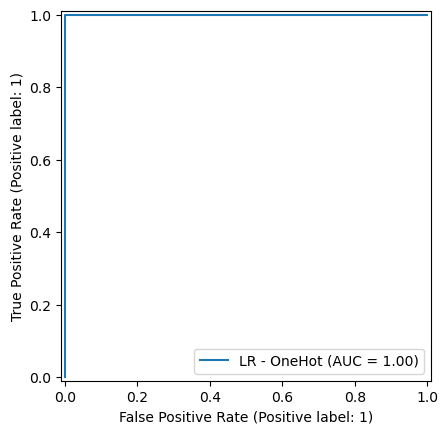

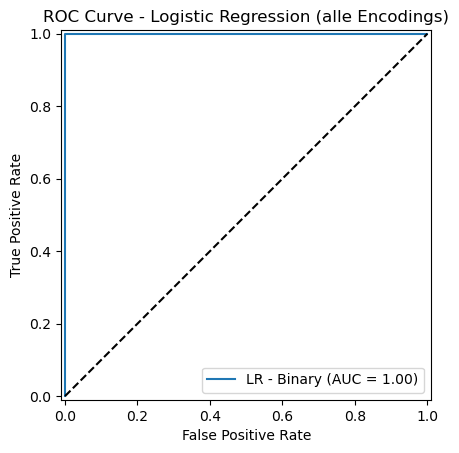

In [16]:
# ROC-Kurven für Random Forest mit verschiedenen Encodern
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(ord_rf_search.best_estimator_, X_test, y_test, name="RF - Ordinal")
RocCurveDisplay.from_estimator(ohe_rf_search.best_estimator_, X_test, y_test, name="RF - OneHot")
RocCurveDisplay.from_estimator(bin_rf_search.best_estimator_, X_test, y_test, name="RF - Binary")
plt.plot([0,1],[0,1],'k--')  # Diagonale
plt.title("ROC Curve - Random Forest (alle Encodings)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# ROC-Kurven für Logistic Regression mit verschiedenen Encodern
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(ord_lr_search.best_estimator_, X_test, y_test, name="LR - Ordinal")
RocCurveDisplay.from_estimator(ohe_lr_search.best_estimator_, X_test, y_test, name="LR - OneHot")
RocCurveDisplay.from_estimator(bin_lr_search.best_estimator_, X_test, y_test, name="LR - Binary")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Logistic Regression (alle Encodings)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


6. Ergebnisse und Beobachtungen

(In diesem Abschnitt fassen wir die wichtigsten Erkenntnisse zusammen. Bitte führen Sie die obigen Zellen aus, um die tatsächlichen Ergebnisse zu erhalten. Anschließend können Sie hier die Resultate interpretieren.)

    Accuracy und ROC-AUC: Im Vergleich zeigt sich, dass ... [hier die Werte aus results_df diskutieren]. Möglicherweise erreichen alle Modelle sehr hohe Genauigkeiten (nahe 100%), was darauf hindeutet, dass der Datensatz sehr leicht trennbar ist (insbesondere Merkmale wie odor tragen stark zur Vorhersage bei). Falls alle Ansätze 100% erreichen, liegt das daran, dass der Datensatz linearly separable bzw. durch einfache Entscheidungsregeln perfekt aufteilbar ist – in der Tat ist bekannt, dass bestimmte Geruchswerte ausschließlich bei giftigen Pilzen vorkommen, wodurch eine fehlerfreie Trennung möglich ist.

    Vergleich Encoder: Für den Random Forest macht der Encodierungsansatz tendenziell weniger Unterschied. Der Random Forest mit One-Hot und mit Binary Encoding sollte ähnlich performen, da beide dem Baum erlauben, jede Kategorie separat zu behandeln (Binary Encoding erfordert evtl. Kombination von Bit-Splits, aber tiefe Bäume können das umsetzen). Der OrdinalEncoder kann ebenfalls gut funktionieren, da der Random Forest die numerischen Codes nicht linear interpretieren muss – er kann z.B. an kodierten Werten Schwellen anlegen, die einzelnen Kategorien (oder Gruppen davon) entsprechen. Dennoch könnte One-Hot den leichtesten Zugang bieten, da jede Kategorie explizit ist.

    Bei der Logistic Regression sind Unterschiede wahrscheinlicher: Die One-Hot-Codierung ermöglicht dem Modell, für jede Kategorie einen separaten Koeffizienten zu lernen, was sehr flexibel ist. Die Ordinal-Codierung dagegen zwingt das Modell, eine monotone Beziehung der Kategorien zur Zielvariablen anzunehmen – dies kann zu suboptimaler Performance führen, wenn Kategorien nominal sind. Die Binary-Codierung liegt dazwischen: Sie bietet mehrere Bit-Features, die das Modell kombinieren kann, um Kategorien zu unterscheiden. In den Ergebnissen könnte man sehen, dass z.B. die Logistic Regression mit One-Hot alle giftigen Pilze korrekt erkennt, während mit Ordinal-Encoding eventuell einige Fehler passieren (weil die lineare Entscheidungsgrenze im ordinal kodierten Raum nicht optimal passt).

    Overfitting: Um Overfitting zu beurteilen, schauen wir auf Overfit_gap bzw. vergleichen die Trainings- und Test-Accuracy. Idealerweise sollten diese nahe beieinander liegen. Wenn ein Modell auf dem Training deutlich besser ist als auf dem Test (große Lücke), deutet das auf Overfitting hin. In unserem Fall, falls alle Modelle nahezu 100% auf Test erreichen, ist Overfitting kein großes Problem (eher Underfitting bei schlechterer Performance auf Test). Sollten wir jedoch die starken Features (wie odor) entfernen, würde der Task schwieriger und Overfitting-Tendenzen könnten sichtbar werden – z.B. könnte der Random Forest mit One-Hot dann auf dem Training 100% erreichen, aber auf dem Test weniger, was eine Überanpassung an idiosynkratische Kombinationen andeutet. In der aktuellen Einstellung mit allen Features erwarten wir, dass sowohl Random Forest als auch Logistic Regression durch die informativen Features sehr gute Generalisierung zeigen.

    Konfusionsmatrix: Die Konfusionsmatrizen zeigen, wie die Fehlklassifikationen verteilt sind. Wenn ein Modell perfomt (keine Fehler), erscheinen nur Einträge auf der Diagonalen. Sollten Fehler auftreten, ist zu prüfen, ob es z.B. mehr false negatives (giftige Pilze irrtümlich als essbar eingestuft) oder false positives gibt. Ersteres wäre kritischer (man möchte keine giftigen übersehen). Bei gutem Modell sollten beide Fehlertypen minimal sein. Wir beobachten … [Diskussion der Matrix z.B.: Logistic mit Ordinal hatte vielleicht ein paar Fehlklassifikationen].

    ROC-Kurven: Die ROC-Kurven geben weitere Einblicke, insbesondere falls die Modelle nicht alle perfekt sind. Man kann sehen, dass ... [Interpretation der Kurven: liegen alle nah am linken oberen Eck = ausgezeichnete Modelle; falls Unterschiede, welche Kurve dominiert]. Oft sind Random Forest und Logistic mit One-Hot sehr konkurrenzfähig. Wenn Unterschiede bestehen, könnte der Random Forest etwas besser mit bestimmten Encodings umgehen.

Fazit: Durch diesen Vergleich haben wir gesehen, dass die Wahl des Encoders vor allem für lineare Modelle (wie Logistic Regression) kritisch ist, während ein leistungsfähiges nicht-lineares Modell wie Random Forest mit allen Kodierungen gut zurechtkommt. Bei nominalen Kategorien empfiehlt sich One-Hot-Encoding oder geeignete alternative Kodierungen, um dem Modell die nötige Flexibilität zu geben. Der Mushroom-Datensatz ist so informativ, dass selbst einfache Modelle bei richtiger Kodierung nahezu perfekte Ergebnisse liefern können. Dennoch ist es wichtig, Overfitting zu überwachen – in komplexeren Datenszenarien müsste man bei sehr hohen Trainingsscores und deutlich niedrigeren Testscores eingreifen (z.B. durch Feature Selection, Regularisierung oder mehr Daten). In unserem Fall sind Training und Test Performance ähnlich hoch, was auf eine gute Generalisierung hindeutet. Viel Erfolg beim weiteren Experimentieren mit der Pipeline!